### Step1: Import Environment

In [ ]:
import os
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import pickle
import numpy as np
import wandb
import pandas as pd 
from pprint import pprint
from copy import deepcopy
from dataclasses import dataclass, field
import matplotlib
import matplotlib.pyplot as plt
import re
import torch
from numpy.linalg import svd

### Step2: Define Loss Function

In [3]:
def compute_loss(eval_model, data_loader) -> float:

    total_loss = 0
    sample_cnt = 0
    eval_model.eval()
    with torch.no_grad():
        for lm_input in data_loader:
            batch_loss = eval_model(**{'input_ids':lm_input['input_ids_with_ans'], 
                                        'attention_mask':lm_input['attention_mask_with_ans'],
                                        'labels':lm_input['labels_with_ans']}).loss.item()
            total_loss += batch_loss*(lm_input['input_ids_with_ans'].shape[0])
            sample_cnt += lm_input['input_ids_with_ans'].shape[0]

    total_loss = total_loss/sample_cnt

    return total_loss

### Step3: Compute Loss of Task 0 and Task 1 for each point

In [ ]:

from pathlib import Path
cwd = Path('/dev_data/zjh/LLM_CL/')
import os
os.chdir(cwd)
from main_CL import *
from utils.evaluation import evaluate_sent_level_acc_with_generation


Exp_ID_list = ['SEQ','REPLAY020','REPLAY050'] # 'SEQ', 'REPLAY020', 'REPLAY020_Align', 'REPLAY050'
# Exp_ID_list = ['SEQ'] # 'SEQ', 'REPLAY020', 'REPLAY050'

# NOTE:
# 'SEQ': (2024.08.29, Start from model finetuned on Task0, then directly finetune on Task1)
# 'REPLAY020': (2024.09.09, Start from model finetuned on Task0, then directly finetune on Task1 + 20% Task 0 (data replay))
# 'REPLAY050': (2024.09.10, Start from model finetuned on Task0, then directly finetune on Task1 + 50% Task 0 (data replay))

Exp_direction_dict = {
    'SEQ': {
        # Direction 1
        'ft_ckpt_xbase_id': 'checkpoint-100', 
        'ft_ckpt_xaxis_id': 'checkpoint-150', 
        'ckpt_xbase': f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/fine_tuning/1_1_first_200steps_eval_every_step/checkpoint-100',  
        'ckpt_xaxis': f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/fine_tuning/1_1_first_200steps_eval_every_step/checkpoint-150',  
        # Direction 2
        'ft_ckpt_ybase_id': 'checkpoint-150', 
        'ft_ckpt_yaxis_id': 'checkpoint-62500',
        'ckpt_ybase': f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/fine_tuning/1_1_first_200steps_eval_every_step/checkpoint-150',  
        'ckpt_yaxis': f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/fine_tuning/1_1/checkpoint-62500',  
    },
    'REPLAY020':{
        # Direction 1
        'ft_ckpt_xbase_id': 'task_0_epoch_last', 
        'ft_ckpt_xaxis_id': 'task_1_epoch_0_step_199', 
        'ckpt_xbase': f'/dev_data/zjh/LLM_CL/experiments/SOTA-pythia-160m-bio-finetune_task0-saveckpt-REPLAY_0/2024-09-09-15-23-53/checkpoint_llm_task_0_epoch_last',  
        'ckpt_xaxis': f'/dev_data/zjh/LLM_CL/experiments/SOTA-pythia-160m-bio-finetune_task0-saveckpt-REPLAY_0/2024-09-09-15-23-53/checkpoint_llm_task_1_epoch_0_step_199',  
        # Direction 2
        'ft_ckpt_ybase_id': 'task_1_epoch_0_step_199', 
        'ft_ckpt_yaxis_id': 'task_1_epoch_23',
        'ckpt_ybase': f'/dev_data/zjh/LLM_CL/experiments/SOTA-pythia-160m-bio-finetune_task0-saveckpt-REPLAY_0/2024-09-09-15-23-53/checkpoint_llm_task_1_epoch_0_step_199',  
        'ckpt_yaxis': f'/dev_data/zjh/LLM_CL/experiments/SOTA-pythia-160m-bio-finetune_task0-saveckpt-REPLAY_0/2024-09-08-23-10-46/checkpoint_llm_task_1_epoch_23',  
    },
    'REPLAY020_Align':{
        # Direction 1
        'ft_ckpt_xbase_id': 'task_1_epoch_0_step_99', 
        'ft_ckpt_xaxis_id': 'task_1_epoch_0_step_179', 
        'ckpt_xbase': f'/dev_data/zjh/LLM_CL/experiments/SOTA-pythia-160m-bio-finetune_task0-saveckpt-REPLAY_0/2024-09-09-15-23-53/checkpoint_llm_task_1_epoch_0_step_99',  
        'ckpt_xaxis': f'/dev_data/zjh/LLM_CL/experiments/SOTA-pythia-160m-bio-finetune_task0-saveckpt-REPLAY_0/2024-09-09-15-23-53/checkpoint_llm_task_1_epoch_0_step_179',  
        # Direction 2
        'ft_ckpt_ybase_id': 'task_1_epoch_0_step_179', 
        'ft_ckpt_yaxis_id': 'task_1_epoch_0_step_239',
        'ckpt_ybase': f'/dev_data/zjh/LLM_CL/experiments/SOTA-pythia-160m-bio-finetune_task0-saveckpt-REPLAY_0/2024-09-09-15-23-53/checkpoint_llm_task_1_epoch_0_step_179',  
        'ckpt_yaxis': f'/dev_data/zjh/LLM_CL/experiments/SOTA-pythia-160m-bio-finetune_task0-saveckpt-REPLAY_0/2024-09-09-15-23-53/checkpoint_llm_task_1_epoch_0_step_239',  
    },
    'REPLAY050':{
        # Direction 1
        'ft_ckpt_xbase_id': 'task_0_epoch_last', 
        'ft_ckpt_xaxis_id': 'task_1_epoch_0_step_199', 
        'ckpt_xbase': f'/dev_data/zjh/LLM_CL/experiments/SOTA-pythia-160m-bio-finetune_task0-saveckpt-REPLAY_0/2024-09-10-18-43-58/checkpoint_llm_task_0_epoch_last',  
        'ckpt_xaxis': f'/dev_data/zjh/LLM_CL/experiments/SOTA-pythia-160m-bio-finetune_task0-saveckpt-REPLAY_0/2024-09-10-18-43-58/checkpoint_llm_task_1_epoch_0_step_199',  
        # Direction 2
        'ft_ckpt_ybase_id': 'task_1_epoch_0_step_199', 
        'ft_ckpt_yaxis_id': 'task_1_epoch_23',
        'ckpt_ybase': f'/dev_data/zjh/LLM_CL/experiments/SOTA-pythia-160m-bio-finetune_task0-saveckpt-REPLAY_0/2024-09-10-18-43-58/checkpoint_llm_task_1_epoch_0_step_199',  
        'ckpt_yaxis': f'/dev_data/zjh/LLM_CL/experiments/SOTA-pythia-160m-bio-finetune_task0-saveckpt-REPLAY_0/2024-09-09-17-41-48/checkpoint_llm_task_1_epoch_23',  
    }
}

Exp_grid_loss_dict = {}
Exp_xy_unit_norm_dict = {}

for exp_id in Exp_ID_list:

    # Result 
    save_dir = os.path.abspath('./visualization-landscape')

    log_file    = f'log_{exp_id}.txt'

    backbone = 'EleutherAI/pythia-160m-deduped'

    tokenizer = AutoTokenizer.from_pretrained(backbone)

    config_ckpt_xbase = AutoConfig.from_pretrained(Exp_direction_dict[exp_id]['ckpt_xbase'])
    config_ckpt_xaxis = AutoConfig.from_pretrained(Exp_direction_dict[exp_id]['ckpt_xaxis'])
    config_ckpt_ybase = AutoConfig.from_pretrained(Exp_direction_dict[exp_id]['ckpt_ybase'])
    config_ckpt_yaxis = AutoConfig.from_pretrained(Exp_direction_dict[exp_id]['ckpt_yaxis'])

    model_xbase = AutoModelForCausalLM.from_pretrained(Exp_direction_dict[exp_id]['ckpt_xbase'], config=config_ckpt_xbase) 
    model_xaxis = AutoModelForCausalLM.from_pretrained(Exp_direction_dict[exp_id]['ckpt_xaxis'], config=config_ckpt_xaxis) 
    model_ybase = AutoModelForCausalLM.from_pretrained(Exp_direction_dict[exp_id]['ckpt_ybase'], config=config_ckpt_ybase) 
    model_yaxis = AutoModelForCausalLM.from_pretrained(Exp_direction_dict[exp_id]['ckpt_yaxis'], config=config_ckpt_yaxis) 

    # 61 * 61 models
    n_model = 61

    params = get_params(default_cfg_path='./config/CIT/biography_qa_task6_test_only/SEQ.yaml',is_run_in_ipynb=True)
    params.__setattr__('backbone_cache_path', Exp_direction_dict[exp_id]['ckpt_xbase'])
    params.__setattr__('load_llm_ckpt',True)

    # Initialize Accelerator
    accelerator = Accelerator()
    # Dataset
    CL_dataset = get_dataset(params)
    model = get_model(params, CL_dataset, accelerator)  

    tmp_x_unit, tmp_y_unit = [], []
    for (n1,p1), (n2,p2), (n3,p3), (n4,p4), (n5,p5) in zip(model_xbase.named_parameters(), 
                                                            model_xaxis.named_parameters(),
                                                            model_ybase.named_parameters(), 
                                                            model_yaxis.named_parameters(),
                                                            model.model.named_parameters()):
        tmp_x_unit.append((p2.data - p1.data).flatten())
        tmp_y_unit.append((p4.data - p3.data).flatten())
    tmp_x_unit = torch.concatenate(tmp_x_unit,dim=0)
    tmp_y_unit = torch.concatenate(tmp_y_unit,dim=0)
    norm_x_unit, norm_y_unit = tmp_x_unit.norm().item(), tmp_y_unit.norm().item()
    ratio_y_to_x = norm_y_unit/norm_x_unit
    Exp_xy_unit_norm_dict[exp_id] = {
        'norm_x_unit': norm_x_unit,
        'norm_y_unit': norm_y_unit,
        'ratio_y_to_x': ratio_y_to_x,
    }
    print(f'norm_x_unit = {norm_x_unit}, norm_y_unit = {norm_y_unit}, ratio_y_to_x = {ratio_y_to_x}')


    if not os.path.isfile(os.path.join(save_dir,log_file)):

        for x_ratio in np.linspace(-0.5,1.5,n_model):

            for y_ratio in np.linspace(-1,2,n_model):

                for (n1,p1), (n2,p2), (n3,p3), (n4,p4), (n5,p5) in zip(model_xbase.named_parameters(), 
                                                                    model_xaxis.named_parameters(),
                                                                    model_ybase.named_parameters(), 
                                                                    model_yaxis.named_parameters(),
                                                                    model.model.named_parameters()):
            
                    assert n1 == n2 and n2 == n3 and n3 == n4 and n4 == n5
                    p5.data = p1.data + (p2.data - p1.data) * x_ratio + (p4.data - p3.data) * y_ratio
                model.model.cuda()

                loss_0 = compute_loss(model.model, model.train_loader_list[0])
                loss_1 = compute_loss(model.model, model.train_loader_list[1])

                print(f'Ratio ({x_ratio},{y_ratio}); Task 0 Loss = {loss_0}; Task 1 Loss = {loss_1}')
                with open(os.path.join(save_dir,log_file),'a') as f:
                    f.write(f'{x_ratio},{y_ratio},{loss_0},{loss_1}\n')

        print(f'Saving loss file to {os.path.join(save_dir,log_file)}')

    print(f'Loading loss file from {os.path.join(save_dir,log_file)}')

    x_coor_list, y_coor_list = [], []
    loss_0_list, loss_1_list = [], []
    with open(os.path.join(save_dir,log_file),'r') as f:
        for line in f.readlines():
            x_ratio, y_ratio, loss_0, loss_1 = line.strip().split(',')
            x_coor_list.append(float(x_ratio))
            y_coor_list.append(float(y_ratio))
            loss_0_list.append(float(loss_0))
            loss_1_list.append(float(loss_1))

        Exp_grid_loss_dict[exp_id] = {
            'x_coor_list': x_coor_list,
            'y_coor_list': y_coor_list,
            'loss_0_list': loss_0_list,
            'loss_1_list': loss_1_list,
        }





### Step4: Compute Trajectory from checkpoints

In [ ]:



Exp_ckpt_dict = {
    'SEQ': 
    ['/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/fine_tuning/1_1_first_200steps_eval_every_step/checkpoint-%d'%(ckpt_id) 
     for ckpt_id in range(10,210,10)]
    + ['/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/fine_tuning/1_1_first_6ksteps_eval_every_200steps/checkpoint-%d'%(ckpt_id) 
       for ckpt_id in range(400,6200,200)]
    + ['/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/fine_tuning/1_1/checkpoint-%d'%(ckpt_id) 
       for ckpt_id in range(6250,62500+6250,6250)],
    
    'REPLAY020':
    ['/dev_data/zjh/LLM_CL/experiments/SOTA-pythia-160m-bio-finetune_task0-saveckpt-REPLAY_0/2024-09-09-15-23-53/checkpoint_llm_task_1_epoch_0_step_%d'%(ckpt_id) 
     for ckpt_id in range(9,209,10)]
    + ['/dev_data/zjh/LLM_CL/experiments/SOTA-pythia-160m-bio-finetune_task0-saveckpt-REPLAY_0/2024-09-09-15-45-32/checkpoint_llm_task_1_epoch_0_step_%d'%(ckpt_id) 
       for ckpt_id in range(249,1049,50)]
    + ['/dev_data/zjh/LLM_CL/experiments/SOTA-pythia-160m-bio-finetune_task0-saveckpt-REPLAY_0/2024-09-08-23-10-46/checkpoint_llm_task_1_epoch_%d'%(ckpt_id) 
       for ckpt_id in range(1,25,2)],

    'REPLAY020_Align':
    ['/dev_data/zjh/LLM_CL/experiments/SOTA-pythia-160m-bio-finetune_task0-saveckpt-REPLAY_0/2024-09-09-15-23-53/checkpoint_llm_task_1_epoch_0_step_%d'%(ckpt_id) 
     for ckpt_id in range(9,249,10)]
    # + ['/dev_data/zjh/LLM_CL/experiments/SOTA-pythia-160m-bio-finetune_task0-saveckpt-REPLAY_0/2024-09-09-15-45-32/checkpoint_llm_task_1_epoch_0_step_%d'%(ckpt_id) 
    #    for ckpt_id in range(249,1049,50)]
    + ['/dev_data/zjh/LLM_CL/experiments/SOTA-pythia-160m-bio-finetune_task0-saveckpt-REPLAY_0/2024-09-08-23-10-46/checkpoint_llm_task_1_epoch_%d'%(ckpt_id) 
       for ckpt_id in range(1,25,2)],

    'REPLAY050':
    ['/dev_data/zjh/LLM_CL/experiments/SOTA-pythia-160m-bio-finetune_task0-saveckpt-REPLAY_0/2024-09-10-18-43-58/checkpoint_llm_task_1_epoch_0_step_%d'%(ckpt_id) 
     for ckpt_id in range(9,209,10)]
    + ['/dev_data/zjh/LLM_CL/experiments/SOTA-pythia-160m-bio-finetune_task0-saveckpt-REPLAY_0/2024-09-10-21-51-29/checkpoint_llm_task_1_epoch_0_step_%d'%(ckpt_id) 
       for ckpt_id in range(249,1049,50)]
    + ['/dev_data/zjh/LLM_CL/experiments/SOTA-pythia-160m-bio-finetune_task0-saveckpt-REPLAY_0/2024-09-09-17-41-48/checkpoint_llm_task_1_epoch_%d'%(ckpt_id) 
       for ckpt_id in range(1,25,2)]
}

Exp_trajectory_coor_dict = {}

for exp_id in Exp_ID_list:

    coor_save_dir = os.path.abspath('./visualization-landscape')
    coor_save_file = f'coor_{exp_id}.txt'

    if not os.path.isfile(os.path.join(coor_save_dir,coor_save_file)):

        config_ckpt_xbase = AutoConfig.from_pretrained(Exp_direction_dict[exp_id]['ckpt_xbase'])
        config_ckpt_xaxis = AutoConfig.from_pretrained(Exp_direction_dict[exp_id]['ckpt_xaxis'])
        config_ckpt_ybase = AutoConfig.from_pretrained(Exp_direction_dict[exp_id]['ckpt_ybase'])
        config_ckpt_yaxis = AutoConfig.from_pretrained(Exp_direction_dict[exp_id]['ckpt_yaxis'])

        model_xbase = AutoModelForCausalLM.from_pretrained(Exp_direction_dict[exp_id]['ckpt_xbase'], config=config_ckpt_xbase) 
        model_xaxis = AutoModelForCausalLM.from_pretrained(Exp_direction_dict[exp_id]['ckpt_xaxis'], config=config_ckpt_xaxis) 
        model_ybase = AutoModelForCausalLM.from_pretrained(Exp_direction_dict[exp_id]['ckpt_ybase'], config=config_ckpt_ybase) 
        model_yaxis = AutoModelForCausalLM.from_pretrained(Exp_direction_dict[exp_id]['ckpt_yaxis'], config=config_ckpt_yaxis) 

        
        # Compute the flatten parameters for each direction
        params_cnt = 0
        flatten_name_list = []
        flatten_direction_x, flatten_direction_y = [], []
        for (n1,p1), (n2,p2), (n3,p3), (n4,p4) in zip(model_xbase.named_parameters(), 
                                                        model_xaxis.named_parameters(),
                                                        model_ybase.named_parameters(), 
                                                        model_yaxis.named_parameters()):
            
            assert n1 == n2 and n2 == n3 and n3 == n4
            flatten_direction_x.append((p2.data-p1.data).flatten())
            flatten_direction_y.append((p4.data-p3.data).flatten())
            params_cnt += len((p2.data-p1.data).flatten())
            flatten_name_list.append((n1,params_cnt))
            
        print(flatten_name_list)
        flatten_direction_x = torch.concatenate(flatten_direction_x,dim=0)
        flatten_direction_y = torch.concatenate(flatten_direction_y,dim=0)
        direction_matrix = torch.stack((flatten_direction_x,flatten_direction_y)).T
        # print(direction_matrix.shape) # The basis, torch.Size([162281472, 2]) 


        training_xy_coor_list = []

        for ckpt_path in Exp_ckpt_dict[exp_id]:
            config_ckpt = AutoConfig.from_pretrained(ckpt_path)
            model_training_ckpt = AutoModelForCausalLM.from_pretrained(ckpt_path, config=config_ckpt) 

            flatten_model_training = []
            # NOTE: model_xbase corresponds to the corr (0,0)
            for (n1,p1),(n2,p2) in zip(model_xbase.named_parameters(), model_training_ckpt.named_parameters()):
                flatten_model_training.append((p2.data-p1.data).flatten())
            flatten_model_training = torch.concatenate(flatten_model_training,dim=0).unsqueeze(0).T

            direction_matrix_inverse = torch.linalg.pinv(direction_matrix[:100000,:])
            xy_coor = direction_matrix_inverse @ flatten_model_training[:100000,:]
            
            del flatten_model_training
            del model_training_ckpt

            x_coor = xy_coor[0].item()
            y_coor = xy_coor[1].item()
            
            print((x_coor,y_coor))
            training_xy_coor_list.append((x_coor,y_coor))
        training_xy_coor_list = np.array(training_xy_coor_list)

        with open(os.path.join(coor_save_dir,coor_save_file),'w') as f:
            np.savetxt(f, training_xy_coor_list)
        print(f'Saving coordinate file to {os.path.join(coor_save_dir,coor_save_file)}')

    with open(os.path.join(coor_save_dir,coor_save_file),'r') as f:
        training_xy_coor_list = np.loadtxt(f)
    print(f'Loading coordinate file from {os.path.join(coor_save_dir,coor_save_file)}')


    Exp_trajectory_coor_dict[exp_id] = training_xy_coor_list

    

### Step5: Plot the contour

<Figure size 640x480 with 0 Axes>

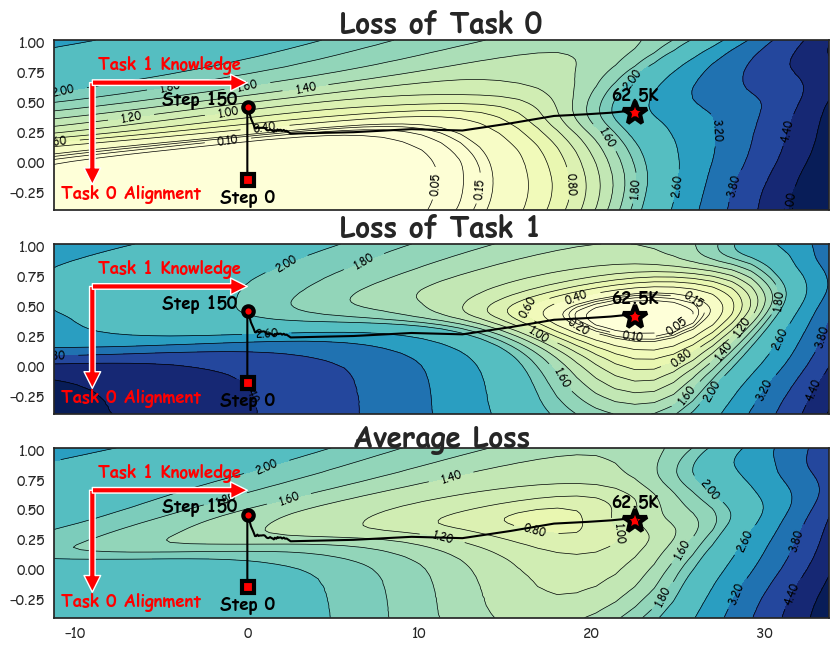

<Figure size 640x480 with 0 Axes>

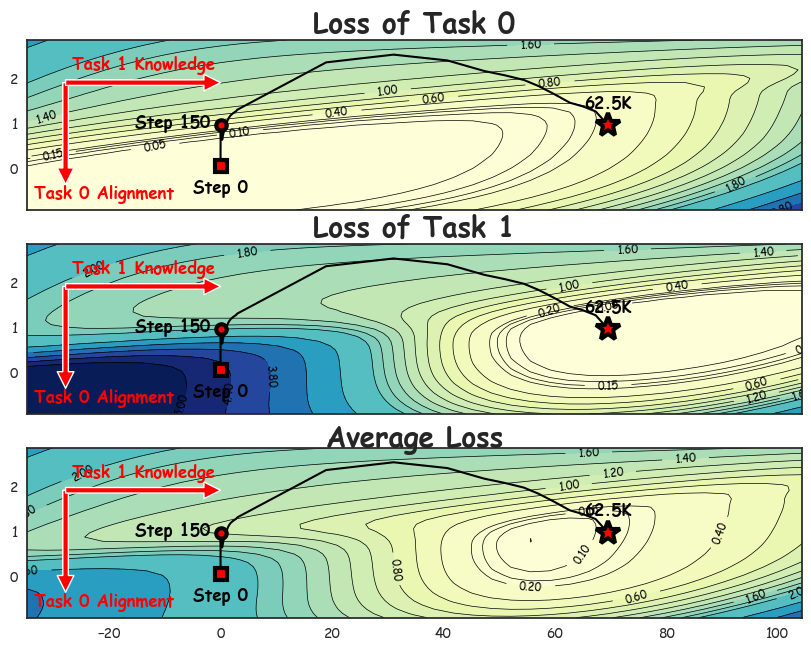

<Figure size 640x480 with 0 Axes>

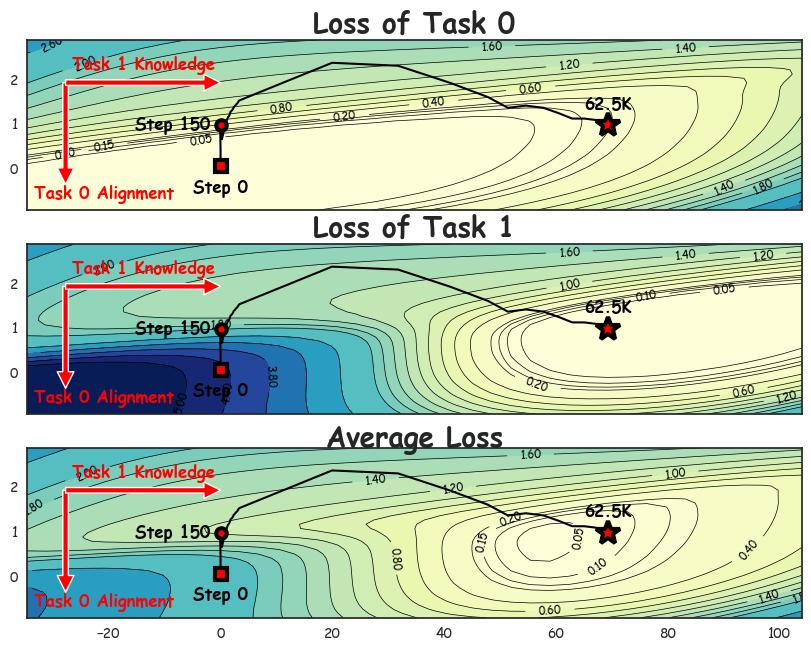

In [13]:

import matplotlib.pyplot as plt
import seaborn as sns
# Exp_ID_list = ['SEQ','REPLAY020','REPLAY050']
def plot_trajectory():

    plt.plot(_training_xy_coor_list[:,0],
        _training_xy_coor_list[:,1],
        linestyle='-',
        color='black',
        linewidth=1.5,
        )
    
    plt.plot(_training_xy_coor_list[0,0],
            _training_xy_coor_list[0,1],
            marker='s',
            color='black',
            markersize=8,
            markerfacecolor='r',
            markeredgecolor='black',
            markeredgewidth=3,
            )
    
    plt.plot(_training_xy_coor_list[19,0],
            _training_xy_coor_list[19,1],
            marker='.',
            color='red',
            markersize=15,
            markerfacecolor='r',
            markeredgecolor='black',
            markeredgewidth=3,
            zorder=5
        )
    
    plt.plot(_training_xy_coor_list[-1,0],
            _training_xy_coor_list[-1,1],
            marker='*',
            markersize=18,
            markerfacecolor='r',
            markeredgecolor='black',
            markeredgewidth=3,
            )

def plot_trajectory_base_annotation():

    x_left, x_right = plt.xlim()
    text_x_offset = (x_right - x_left) * 0.025

    y_bottom, y_top = plt.ylim()
    text_y_offset = (y_top - y_bottom) * 0.10

    plt.text(x=_training_xy_coor_list[0,0],
            y=_training_xy_coor_list[0,1]-text_y_offset,
            horizontalalignment='center',
            verticalalignment='top',
            s='Step 0',
            fontsize=12,
            fontweight='bold',
            color='black')
    
    plt.text(x=_training_xy_coor_list[14,0]-text_x_offset,
            y=_training_xy_coor_list[14,1]+text_y_offset*0.5,
            horizontalalignment='right',
            verticalalignment='bottom',
            s='Step 150',
            fontsize=12,
            fontweight='bold',
            color='black')
    
    plt.text(x=_training_xy_coor_list[-1,0],
            y=_training_xy_coor_list[-1,1]+text_y_offset,
            horizontalalignment='center',
            verticalalignment='bottom',
            s='62.5K',
            fontsize=12,
            fontweight='bold',
            color='black')
    
def plot_trajectory_additional_annotation():
    plt.plot(_training_xy_coor_list[11,0],
            _training_xy_coor_list[11,1],
            marker='.',
            markersize=8,
            markerfacecolor='r',
            markeredgecolor='r',
            markeredgewidth=3
            )
    plt.text(x=_training_xy_coor_list[11,0],
            y=_training_xy_coor_list[11,1],
            horizontalalignment='center',
            verticalalignment='center',
            s='110',
            fontsize=12,
            fontweight='bold',
            color='black')
    plt.plot(_training_xy_coor_list[14,0],
            _training_xy_coor_list[14,1],
            marker='.',
            markersize=8,
            markerfacecolor='r',
            markeredgecolor='r',
            markeredgewidth=3
            )
    plt.text(x=_training_xy_coor_list[14,0],
            y=_training_xy_coor_list[14,1],
            horizontalalignment='center',
            verticalalignment='center',
            s='140',
            fontsize=12,
            fontweight='bold',
            color='black')
    plt.plot(_training_xy_coor_list[18,0],
            _training_xy_coor_list[18,1],
            marker='.',
            markersize=8,
            markerfacecolor='r',
            markeredgecolor='r',
            markeredgewidth=3
            )
    plt.text(x=_training_xy_coor_list[18,0],
            y=_training_xy_coor_list[18,1],
            horizontalalignment='center',
            verticalalignment='center',
            s='180',
            fontsize=12,
            fontweight='bold',
            color='black')
    plt.plot(_training_xy_coor_list[23,0],
            _training_xy_coor_list[23,1],
            marker='.',
            markersize=8,
            markerfacecolor='r',
            markeredgecolor='r',
            markeredgewidth=3
            )
    plt.text(x=_training_xy_coor_list[23,0],
            y=_training_xy_coor_list[23,1],
            horizontalalignment='center',
            verticalalignment='center',
            s='1K',
            fontsize=12,
            fontweight='bold',
            color='black')
    plt.plot(_training_xy_coor_list[49,0],
            _training_xy_coor_list[49,1],
            marker='.',
            markersize=8,
            markerfacecolor='r',
            markeredgecolor='r',
            markeredgewidth=3
            )
    plt.text(x=_training_xy_coor_list[49,0],
            y=_training_xy_coor_list[49,1],
            horizontalalignment='center',
            verticalalignment='center',
            s='6K',
            fontsize=12,
            fontweight='bold',
            color='black')
    plt.plot(_training_xy_coor_list[52,0],
            _training_xy_coor_list[52,1],
            marker='.',
            markersize=8,
            markerfacecolor='r',
            markeredgecolor='r',
            markeredgewidth=3
            )
    plt.text(x=_training_xy_coor_list[52,0],
            y=_training_xy_coor_list[52,1],
            horizontalalignment='center',
            verticalalignment='center',
            s='25K',
            fontsize=12,
            fontweight='bold',
            color='black')

def annotate_directions(x_ori = 0.05, y_ori = 0.75, x1 = 0.05, y1 = 0.15, x2 = 0.25, y2 = 0.75):
    
    x_left, x_right = plt.xlim()
    y_bottom, y_top = plt.ylim()

    x1 = x_left + (x_right - x_left) * x1
    x2 = x_left + (x_right - x_left) * x2
    x_ori = x_left + (x_right - x_left) * x_ori
    y1 = y_bottom + (y_top - y_bottom) * y1
    y2 = y_bottom + (y_top - y_bottom) * y2
    y_ori = y_bottom + (y_top - y_bottom) * y_ori

    plt.annotate('', xy= (x1, y1), xytext=(x_ori, y_ori),
                #  xycoords='axes fraction',
                arrowprops=dict(facecolor='red'),
                horizontalalignment='left',
                verticalalignment='bottom',
    )
    x_right, x_left = plt.xlim()
    text_x_offset = (x_right - x_left) * 0.05
    plt.text(x=x1-text_x_offset, y=y1, s='Task 0 Alignment', 
            fontsize=12, 
            fontweight='bold',
            color='red',
            horizontalalignment='center',
            verticalalignment='top',)

    plt.annotate('', xy= (x2, y2), xytext=(x_ori, y_ori),
                #  xycoords='axes fraction',
                arrowprops=dict(facecolor='red'),
                horizontalalignment='left',
                verticalalignment='bottom',
    )
    y_bottom, y_top = plt.ylim()
    text_y_offset = (y_top - y_bottom) * 0.05
    plt.text(x=(x2+x_ori)/2, y=y2+text_y_offset, s='Task 1 Knowledge', 
            fontsize=12, 
            fontweight='bold',
            color='red',
            horizontalalignment='center',
            verticalalignment='bottom',)


Exp_xylimit_dict = {
    'SEQ': {
        'x_limit': (-1,   2.5),
        'y_limit': (-0.5, 1.5)
    },
    'REPLAY020': {
        'x_limit': (-1,   3.0),
        'y_limit': (-0.5, 1.5)
    },
    'REPLAY020_Align': {
        'x_limit': (-1,   7),
        'y_limit': (-0.5, 12)
    },
    'REPLAY050': {
        'x_limit': (-1,   3.0),
        'y_limit': (-0.5, 1.5)
    }
}

for exp_id in Exp_ID_list:
    
    sns.set_theme(style="white", palette=None)
    plt.clf()
    plt.rcParams['font.sans-serif'] = 'Comic Sans MS' # 'Comic Sans MS' # 'DejaVu Sans'

    levels = list(np.linspace(0,    0.2,    4,     endpoint=False)) + \
            list(np.linspace(0.2,  2.0,    9,   endpoint=False)) + \
            list(np.linspace(2,    5,      6,     ))
    cmap = "YlGnBu" # "YlGnBu" # "RdBu_r"

#     ratio_y_to_x = 50

#     X = np.reshape(np.array(Exp_grid_loss_dict[exp_id]['x_coor_list']),(-1,n_model)).T/ratio_y_to_x # rescale the x according the ratio
#     Y = np.reshape(np.array(Exp_grid_loss_dict[exp_id]['y_coor_list']),(-1,n_model)).T

    # rescale x and y according to the norm
    x_unit_norm, y_unit_norm = Exp_xy_unit_norm_dict[exp_id]['norm_x_unit'], Exp_xy_unit_norm_dict[exp_id]['norm_y_unit'] 
    X = np.reshape(np.array(Exp_grid_loss_dict[exp_id]['x_coor_list']),(-1,n_model)).T * x_unit_norm
    Y = np.reshape(np.array(Exp_grid_loss_dict[exp_id]['y_coor_list']),(-1,n_model)).T * y_unit_norm
    _Y, _X = X, Y # NOTE: Swap x and y for better presentation
    Z1 = np.reshape(np.array(Exp_grid_loss_dict[exp_id]['loss_0_list']),(-1,n_model)).T
    Z2 = np.reshape(np.array(Exp_grid_loss_dict[exp_id]['loss_1_list']),(-1,n_model)).T

    _training_xy_coor_list = np.zeros_like(Exp_trajectory_coor_dict[exp_id])
#     _training_xy_coor_list[:,0] = Exp_trajectory_coor_dict[exp_id][:,1]
#     _training_xy_coor_list[:,1] = Exp_trajectory_coor_dict[exp_id][:,0]/ratio_y_to_x
    _training_xy_coor_list[:,0] = Exp_trajectory_coor_dict[exp_id][:,1] * y_unit_norm
    _training_xy_coor_list[:,1] = Exp_trajectory_coor_dict[exp_id][:,0] * x_unit_norm

#     _x_limit = Exp_xylimit_dict[exp_id]['y_limit'][0], Exp_xylimit_dict[exp_id]['y_limit'][1]
#     _y_limit = Exp_xylimit_dict[exp_id]['x_limit'][0]/ratio_y_to_x, Exp_xylimit_dict[exp_id]['x_limit'][1]/ratio_y_to_x
    
    _x_limit = Exp_xylimit_dict[exp_id]['y_limit'][0] * y_unit_norm, Exp_xylimit_dict[exp_id]['y_limit'][1] * y_unit_norm
    _y_limit = Exp_xylimit_dict[exp_id]['x_limit'][0] * x_unit_norm, Exp_xylimit_dict[exp_id]['x_limit'][1] * x_unit_norm

    if exp_id == 'REPLAY020_Align':
        # continue
        plt.subplots(3, 1, figsize=(5,30), height_ratios=[5, 5, 5])
        # plt.subplots(2, 1, figsize=(5,20), height_ratios=[5, 5])
    else:
        plt.subplots(3, 1, figsize=(10,7.5), height_ratios=[5, 5, 5])
        # plt.subplots(2, 1, figsize=(10,5), height_ratios=[5, 5])

    plt.subplot(3,1,1)
    plot_trajectory()
    plot_trajectory_base_annotation()
    cntr1 = plt.contour(_X,_Y,Z1, linestyles='solid', levels=levels, linewidths=0.5, colors='k')
    plt.clabel(cntr1,inline=True, fontsize=8, zorder=1.5)
    cntr1 = plt.contourf(_X,_Y,Z1,linestyles='solid', levels=levels, cmap=cmap, extend='both') 
    plt.title('Loss of Task 0', fontsize=20, fontweight='bold', pad=1.5)
    plt.xlim(_x_limit)
    plt.ylim(_y_limit)
    plt.xticks(ticks=[],labels='')
    plt.tick_params(axis='both', labelsize=10, pad=0)
    annotate_directions()
    # plt.colorbar(cntr1)


    plt.subplot(3,1,2)
    plot_trajectory()
    plot_trajectory_base_annotation()
    cntr2 = plt.contour(_X,_Y,Z2, linestyles='solid', levels=levels, linewidths=0.5, colors='k')
    plt.clabel(cntr2,inline=True,fontsize=8,zorder=1.5)
    cntr2 = plt.contourf(_X,_Y,Z2, linestyles='solid', levels=levels, cmap=cmap, extend='both') 
    plt.title('Loss of Task 1', fontsize=20, fontweight='bold', pad=1.5)
    plt.xlim(_x_limit)
    plt.ylim(_y_limit)
    plt.xticks(ticks=[],labels='')
    plt.tick_params(axis='both', labelsize=10, pad=0)
    annotate_directions()
    # plt.colorbar(cntr2)

    plt.subplot(3,1,3)
    plot_trajectory()
    plot_trajectory_base_annotation()
    cntr3 = plt.contour(_X,_Y,(Z1+Z2)/2, linestyles='solid', levels=levels, linewidths=0.5, colors='k')
    plt.clabel(cntr3,inline=True,fontsize=8,zorder=1.5)
    cntr3 = plt.contourf(_X,_Y,(Z1+Z2)/2, linestyles='solid',levels=levels, cmap=cmap, extend='both') 
    plt.title('Average Loss', fontsize=20, fontweight='bold', pad=1.5)
    plt.xlim(_x_limit)
    plt.ylim(_y_limit)
    plt.tick_params(axis='both', labelsize=10, pad=0)
    annotate_directions()
    # plt.colorbar(cntr3)

    save_dir = os.path.abspath('./visualization-landscape')
    save_name = 'landscape'
    plt.savefig(os.path.join(save_dir,f'{save_name}-{exp_id}.pdf'),dpi=1200,bbox_inches='tight',facecolor='white')
    plt.savefig(os.path.join(save_dir,f'{save_name}-{exp_id}.png'),dpi=1200,bbox_inches='tight',facecolor='white')
    plt.show()

